**CPD with Two core updates**
    

Anh-Huy Phan

In [1]:
import numpy as np
from tensorly.tenalg import khatri_rao
from tensorly.tenalg.core_tenalg import mttkrp

from tensorly.random import random_cp
import matplotlib.pyplot as plt
from tensorly.decomposition._cp import initialize_cp
from tensorly.cp_tensor import (
    CPTensor,
    unfolding_dot_khatri_rao,
    cp_norm,
    cp_normalize,
    validate_cp_rank,
    cp_to_tensor
)
from scipy.sparse.linalg import svds
import time
from tqdm import tqdm

import tensorly.decomposition


In [43]:
#-------------------------------------------------------------------------------
# ADMM routine
#-------------------------------------------------------------------------------
 
import numpy as np
import scipy.linalg
import scipy.sparse.linalg

def linreg_krp(Ymn, Phi, rho, szXnm, X0,maxiters,T=None, verbose = False):
    # ADMM
    #   solve min||Y-Phi*Z^T||^2_f  
    #   s.t. Z= X 
    #   """
    # szY(1) = [I1 I2 R]
    R = szXnm[2]
    Q = scipy.linalg.inv(Phi.T @ Phi + rho * np.eye(R))
    B = Ymn.T @ Phi
    
    if T is None:
      T = np.zeros([szXnm[0]*szXnm[1],R])
      
    normY = np.linalg.norm(Ymn,'fro')**2
    
    X = X0 
    Z = X
    f0 = np.linalg.norm(Ymn - Phi @ X.T, 'fro')**2/ normY
    loss_history = [] 
    
    primal_residual_history = []
    # Define the parameters of the rule
    mu = 10 # Residual ratio threshold
    tau = 2 # Rho scaling factor

    
    for kiter in range(maxiters):
        Z_old = Z
          
        # Update Z
        Z = np.matmul(B + rho * (X + T), Q)
        # print(Z)
        
        # Update X
        D = Z - T
        D = D.reshape(szXnm[1],szXnm[0],szXnm[2])
        F1 = np.zeros((szXnm[0], R))
        F2 = np.zeros((szXnm[1], R)) 
        S = np.zeros((R))
        for r in range(R):
          u, s, v = svds(D[:, :, r].T, k=1)
        
          F1[:, r:r+1] = u
          F2[:, r:r+1] = v.T
          S[r] = s
          #X[:, r:r+1] = np.kron(v.T, u) * s
        
        X = khatri_rao([F2,F1 @ np.diag(S)])

        # update T
        T = T + X - Z
        
        # Compute the objective function value
        loss = np.linalg.norm(Ymn - Phi @ Z.T, 'fro')**2/ normY # f(Z) + i(X) 
        
        # Compute the primal residual
        r = Z - X
        # dual residual
        s = rho * (Z - Z_old)
        # Compute the primal and dual residual norms
        norm_r = np.linalg.norm(r,'fro')
        norm_s = np.linalg.norm(s,'fro')  

        loss_history.append(loss)
        primal_residual_history.append(norm_r/ np.linalg.norm(Z,'fro'))
 
        if verbose== True:
            print(f'kiter {kiter} | f = {loss} | d(Z,X) {primal_residual_history[-1]} | rho {rho}') 
        
        if (kiter>5) and (loss<=1e-6) and (primal_residual_history[-1]<=1e-5):
            break 
        
    return X, Z, F1, F2,S,loss_history, primal_residual_history, T, rho


In [3]:
def solver(Y,R,Y_hat,rho,maxoutiters,maxiters,min_rho_stable):
    # maxoutiters = 100
    # rho = 1e1
    # maxiters = 10
    modes = len(Y.shape)
    szY = np.array(Y.shape) 
 
    normY = np.linalg.norm(Y.reshape(-1))**2
    mainloss_history = []

    rho_stable = rho
    counter = 0
    flag = 0

    for kiter in range(maxoutiters):
    
        for n in range(modes-1):
            m = n+1 # can change the mode m 
                           
            modes_1 = np.sort([n, m])
            modes_2 = np.sort(np.setdiff1d(np.arange(modes), modes_1))
             
            sz2 = np.prod(szY[modes_2])
            sz1 = np.prod(szY[modes_1])
            
            # unfolding mode-(n,m)    
            Y_nm = np.transpose(Y, axes = [*modes_2, *modes_1])
            # print(Y_nm.shape)
            Y_nm = Y_nm.reshape(sz2, sz1,  order = 'F')
            
            szXnm = [szY[modes_1[0]], szY[modes_1[1]], R]
    
            # initialize X0
            U_in = Y_hat.factors[modes_1[0]].copy()
            V_in = Y_hat.factors[modes_1[1]].copy()
            X0 = khatri_rao([V_in, U_in@np.diag(Y_hat.weights)])
    
            # Compute Phi
            Factorx2 = [Y_hat.factors[i] for i in modes_2[::-1]]
            Phi = khatri_rao(Factorx2)                      
    
            # solve sub-problem
            fcurr = np.linalg.norm(Y_nm - Phi @ X0.T, 'fro')**2/ normY

            while 1:
                X, Z, Unew, Vnew, Snew, loss_history, dZ, T , rhonew = linreg_krp(Y_nm, Phi, rho, szXnm, X0,maxiters,T=None,verbose = False)

                if loss_history[-1]> fcurr*10 :
                    # fail case
                    rho = rho*1.1
                else:
                    break
                
                
            
            # reject the update if the loss increases
            # if (kiter>2) and (loss_history[-1]>mainloss_history[-1]+np.abs(mainloss_history[-2]-mainloss_history[-1])*.2):
            #     continue 
            # else:
            Y_hat.factors[modes_1[0]] = Unew
            Y_hat.factors[modes_1[1]] = Vnew
            Y_hat.weights = Snew                
    
            print(f'kiter {kiter: 2.2f} | f = {loss_history[-1]:2.4e} | d(Z,X) {dZ[-1]:2.4e} |  rho {rho_stable: .4e}')

            mainloss_history.append(loss_history[-1])

             # If the loss function value is smaller than the previous 10 values, increment the counter by one and set the flag to True
            if (len(mainloss_history)>5) and (kiter > 1) and (loss_history[-1] <= np.min(mainloss_history[-5:])):
                counter += 1
                flag = 1
            else:
                counter = 0
                flag = 0
    
            # If the counter reaches 10 and the error is smaller than 1e-6, reduce rho by a factor of 0.9 or 0.95, and reset the counter to zero
            if (counter == 2) and (dZ[-1] < 1e-6):
                rho = rho * 0.95
                counter = 0
            
            # If the loss function value is larger than the previous value, reduce the counter by one
            if (len(mainloss_history)>2) and (kiter > 1) and (loss_history[-1] > mainloss_history[-2]):
                counter -= 1
            
            # If the counter is negative, increase rho by a small amount (e.g., 0.1) until it reaches rho_stable, and reset the counter to zero
            if counter < 0:
                rho = min(rho + 0.1, rho_stable)
                counter = 0
            
            # Update rho_stable to be the minimum of rho and rho_stable only when the flag is True
            if flag == 1:
                rho_stable = max(min_rho_stable,min(rho, rho_stable) )
                
        if (kiter > 5) and (mainloss_history[-1]<=1e-6) and (dZ[-1]<=1e-4):
            break
 
    return Y_hat, mainloss_history



In [4]:
def cp_sensitivity(CPtensor):
 
    N = len(CPtensor.factors)
    CPtensor = tensorly.cp_tensor.cp_normalize(CPtensor)
    Factors = [x @ np.diag(pow(CPtensor.weights,1/N)) for x in CPtensor.factors]
    C = [x.T @ x  for x in Factors]
    C = np.array(C)
    sensitivity = 0
    for n in range(N):
        # Create a numpy array of numbers from 1 to N
        array = np.arange(0, N)
        
        # Remove the element at index n-1
        array = np.delete(array,n-1)
        sensitivity = sensitivity+ np.trace(np.prod(C[array,:,:],axis = 0))
        
    return sensitivity

**Generate tensors for CPD**

In [5]:
R = 10
szY = [8,8,8,8]
szY = [15,16,17,18] 
szY = np.array(szY)

N = len(szY)
Factors = [np.random.randn(szY[n],R) for n in range(N)]
#Factors = [np.random.rand(szY[n],R) for n in range(N)]

weights_init = np.ones(R)
Y_hat = CPTensor((weights_init, Factors))

# Y is a tensor of rank R
Y = cp_to_tensor(Y_hat) 
 

In [13]:
weights_init

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [7]:
# CHECK two-modes unfoldings 
modes = len(Y.shape)
szY = np.array(Y.shape)

for n in range(N-1):
    for m in range(n+1,N): 
        
        modes_1 = np.sort([n, m])
        modes_2 = np.sort(np.delete(np.arange(modes), modes_1))

        #### Yt = (Uk kr Ui)(Uj kr U1)^T != n, m
        sz2 = np.prod(szY[modes_2])
        sz1 = np.prod(szY[modes_1])

        # unfolding mode-(n,m)    
        Y_nm = np.transpose(Y, axes = [*modes_2, *modes_1])
        Y_nm = Y_nm.reshape(sz2, sz1,  order = 'F')

        A = khatri_rao([Y_hat.factors[modes_1[1]], Y_hat.factors[modes_1[0]]])
        Phi = khatri_rao([Y_hat.factors[modes_2[1]], Y_hat.factors[modes_2[0]]])

        print(np.linalg.norm(Y_nm - Phi @ A.T))



9.949155284429223e-14
1.0093364173272546e-13
8.390666326139019e-14
8.407550824863128e-14
1.0090744753623562e-13
9.931168993344486e-14


[[-0.03434214]
 [-0.26964548]
 [-0.31756154]
 [-0.14050226]
 [ 0.30607296]
 [ 0.00234671]
 [-0.11536258]
 [ 0.25391507]
 [-0.11483983]
 [ 0.14294504]
 [-0.22613826]
 [-0.49499221]
 [ 0.22197723]
 [-0.5001126 ]
 [-0.06995988]]
kiter 0 | f = 1.99293205716498e-31 | d(Z,X) 3.704345544361504e-16 | rho 1.0


/var/folders/_j/_0pf83h53mj_4nr6vxqlgdxm0000gn/T/ipykernel_9088/3108543527.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S[r] = s


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


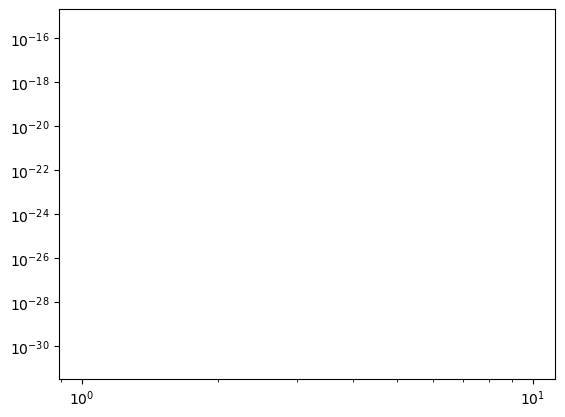

In [ ]:
# Check solver for the subproblem

n = 0
m = 1

modes_1 = np.sort([n, m])
modes_2 = np.sort(np.setdiff1d(np.arange(modes), modes_1))
 
sz2 = np.prod(szY[modes_2])
sz1 = np.prod(szY[modes_1])

# unfolding mode-(n,m)    
Y_nm = np.transpose(Y, axes = [*modes_2, *modes_1])
Y_nm = Y_nm.reshape(sz2, sz1,  order = 'F')

szXnm = [szY[n], szY[m], R]

# initialize X0
U0 = Y_hat.factors[modes_1[0]].copy()
V0 = Y_hat.factors[modes_1[1]].copy()
X0 = khatri_rao([V0, U0@np.diag(Y_hat.weights)])
# X0 = khatri_rao([V_in, U_in])

Factorx2 = [Y_hat.factors[i] for i in modes_2[::-1]]
Phi = khatri_rao(Factorx2)

rho = 1e0
maxiters = 100
X, Z, F1, F2, S, f, dZ, T, rhonew = linreg_krp(Y_nm, Phi, rho, szXnm, X0,maxiters,T = None, verbose = True)

plt.loglog(f)
plt.loglog(dZ)
 


**Initialize the decomposition**

In [25]:
szXnm

[15, 16, 10]

In [21]:
mdic = {"fac1": Factors[0], "fac2": Factors[1], "fac3": Factors[2], "fac4": Factors[3], "facx1": Factorx2[0], "facx2": Factorx2[1], "Phi": Phi, "Y": Y}

In [22]:
from scipy.io import savemat
savemat("matlab_matrix.mat", mdic)

In [46]:
weights_init, factors_init = initialize_cp(Y, init='svd', rank=R)
Y_hat = CPTensor((weights_init, factors_init))


**Main Algorithm**


In [47]:
maxoutiters = 100
rho = 1e-1
maxiters = 10
min_rho_stable = rho
Y_hat, err = solver(Y,R,Y_hat,rho,maxoutiters,maxiters,min_rho_stable)


kiter  0.00 | f = 8.7468e-01 | d(Z,X) 1.5000e+00 |  rho  1.0000e-01
kiter  0.00 | f = 8.2034e-01 | d(Z,X) 1.4396e+00 |  rho  1.0000e-01
kiter  0.00 | f = 6.9833e-01 | d(Z,X) 1.2085e+00 |  rho  1.0000e-01
kiter  1.00 | f = 3.6253e-01 | d(Z,X) 7.1724e-01 |  rho  1.0000e-01
kiter  1.00 | f = 3.3260e-01 | d(Z,X) 7.1219e-01 |  rho  1.0000e-01
kiter  1.00 | f = 2.4211e-01 | d(Z,X) 4.2048e-01 |  rho  1.0000e-01
kiter  2.00 | f = 1.7553e-01 | d(Z,X) 5.5802e-01 |  rho  1.0000e-01
kiter  2.00 | f = 1.4681e-01 | d(Z,X) 2.6829e-01 |  rho  1.0000e-01
kiter  2.00 | f = 1.0621e-01 | d(Z,X) 1.5050e-01 |  rho  1.0000e-01
kiter  3.00 | f = 7.0826e-02 | d(Z,X) 1.2329e-02 |  rho  1.0000e-01
kiter  3.00 | f = 6.2900e-02 | d(Z,X) 1.9624e-02 |  rho  1.0000e-01
kiter  3.00 | f = 6.1158e-02 | d(Z,X) 1.7520e-02 |  rho  1.0000e-01
kiter  4.00 | f = 3.0105e-02 | d(Z,X) 1.4427e-02 |  rho  1.0000e-01
kiter  4.00 | f = 1.8844e-02 | d(Z,X) 8.2816e-03 |  rho  1.0000e-01
kiter  4.00 | f = 1.7183e-02 | d(Z,X) 9.2801e-03

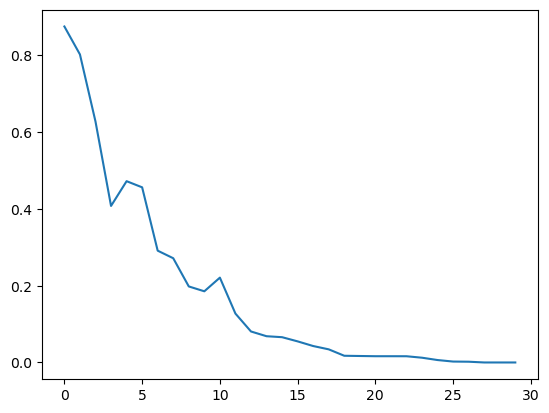

In [44]:
plt.plot(np.array(err).flatten())

In [27]:
Y_hat.weights

array([31.22960657, 30.34443745, 33.24225549, 34.84061653, 31.69649694,
       27.49480708, 35.67619521, 26.35622352, 30.57895136, 33.00660268])

In [25]:

from tensorly.decomposition import parafac
from tensorly.cp_tensor import KruskalTensor

In [48]:
Factor_cp = parafac(Y,R,maxoutiters*3, init = 'svd',verbose=1)


reconstruction error=0.7965803918762276
iteration 1, reconstruction error: 0.5679265487905115, decrease = 0.22865384308571612, unnormalized = 450.3892471443647
iteration 2, reconstruction error: 0.4250957505482563, decrease = 0.1428307982422552, unnormalized = 337.11851552183776
iteration 3, reconstruction error: 0.2939805686164325, decrease = 0.1311151819318238, unnormalized = 233.13875228443874
iteration 4, reconstruction error: 0.20809761420805534, decrease = 0.08588295440837718, unnormalized = 165.03001663737396
iteration 5, reconstruction error: 0.01414167635403195, decrease = 0.19395593785402337, unnormalized = 11.214934360818397
iteration 6, reconstruction error: 0.001139652327743728, decrease = 0.013002024026288223, unnormalized = 0.9037914409740939
iteration 7, reconstruction error: 0.0001572185156591511, decrease = 0.000982433812084577, unnormalized = 0.12468078672440924
iteration 8, reconstruction error: 2.2756214605588166e-05, decrease = 0.00013446230105356295, unnormalized

In [52]:
Y_als = CPTensor(Factor_cp)
Y_als = cp_to_tensor(Y_als) 
err_als = np.linalg.norm((Y_als-Y).reshape(-1))/np.linalg.norm(Y.reshape(-1))
print(err_als**2)

Y_als = CPTensor(Factor_cp)
Y_als = cp_normalize(Y_als)
ss_als = cp_sensitivity(Y_als)
print(ss_als)


3.8388446049804717e-28
155691.74914648655


In [53]:
Y2cu = cp_to_tensor(Y_hat) 
err_2cu = np.linalg.norm((Y2cu-Y).reshape(-1))/np.linalg.norm(Y.reshape(-1))
print(err_2cu**2) 

Y_hat = cp_normalize(Y_hat)
ss_2cup = cp_sensitivity(Y_hat)
print(ss_2cup)

1.3378192649181546e-07
155690.0972381194
